In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sp
import copy

In [2]:
#Exercise 1
#2) P[i] = P(X = X[i])
def discreteRV(P,X):
    #Creating the subdivision
    div = [np.sum(P[0:i]) for i in range(len(P))]
    
    #Sampling the discrete variable
    U = np.random.uniform()
    
    i=0
    
    while (i<len(P) and U>div[i]):
        i+=1
    
    return X[i-1]

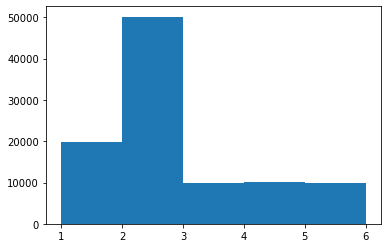

In [3]:
#3)
samples = [discreteRV([0.2,0.5,0.1,0.1,0.1],[1,2,3,4,5]) for _ in range(100000)]

plt.hist(samples,[1,2,3,4,5,6])
plt.show()

The discrete random variable follows the specified probability P, dividing by N gives back the initial probability P given as an argument.

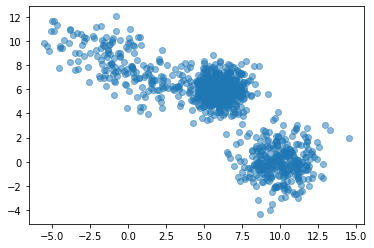

In [4]:
#Exercise 2
#2)
#Parameters
n_samples = 1000
centers=[(6,6),(0,8),(10,0)]
spreads=[[[1, 0], [0, 1]],[[6, -3], [-3, 3.5]],[[2, 0], [0, 2]]]
classProb=[0.5,0.2,0.3]

samples = []

for _ in range(n_samples):
    cl = discreteRV(classProb,range(len(classProb)))
    samples.append(np.random.multivariate_normal(centers[cl], spreads[cl]))

plt.scatter([s[0] for s in samples],[s[1] for s in samples],alpha=0.5)
plt.show()

In [23]:
#3)
def EM(X,k,num_iterations):
    loglikelihood = []
    
    n = len(X)
    d = len(X[0])
    
    xmean = np.mean(X)
    sigma2 = np.sum([np.linalg.norm(x - xmean)**2 for x in X])/n

    #We draw samples at random as initial means for the clusters
    
    Xtemp = copy.deepcopy(X)
    
    mu = np.zeros((k,d))
    for i in range(k):
        r = np.random.randint(len(Xtemp))
        mu[i] = Xtemp[r]
        Xtemp.pop(r)
    
    sigma = np.array([sigma2/k*np.eye(d) for _ in range(k)])
    alpha = np.ones(k)/k
    
    p = np.full((n,k),1/k)
    X = np.array(X) #Sometimes the np float64 mess things up
    
    for _ in range(num_iterations):
        for i in range(n):
            for j in range(k):
                p[i,j] = alpha[j]*sp.multivariate_normal.pdf(x=X[i],mean=mu[j],cov=sigma[j])
            
            p[i] /= np.sum(p[i])
        
        for j in range(k):
            alpha[j] = 0
            mu[j] = np.zeros(d)
            
            for i in range(n):
                alpha[j] += p[i,j]
                mu[j] += p[i,j]*X[i]
                
            mu[j] /= alpha[j]
            
            sigma[j] = np.zeros((d,d))
            for i in range(n):
                v = np.array(X[i] - mu[j]).reshape(-1,1)
                sigma[j] += p[i,j]*v@v.T
            sigma[j] /= alpha[j]
            alpha[j] /= n
          
        loglikelihood.append(np.sum([np.log(np.sum([alpha[j]*sp.multivariate_normal.pdf(x=X[i],mean=mu[j],cov=sigma[j]) for j in range(k)])) for i in range(n)]))
    return alpha, sigma, mu, loglikelihood

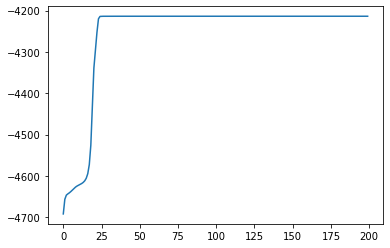

In [6]:
alpha, sigma, mu, loglikelihood = EM(samples,3,200)

plt.plot(loglikelihood)
plt.show()

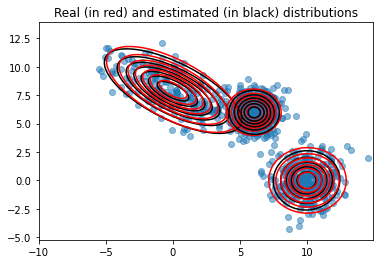


 For the alpha_j (distribution of the latent variables) :
 Real is 
[0.5, 0.2, 0.3]


Estimated is (beware the classes are not sorted in the same order)
[0.19623402 0.31075667 0.49300931]


In [7]:
#4)
x, y = np.mgrid[-10:15:.1, -4:14:.1]
data = np.dstack((x, y))

for i in range(3):
    #Estimated
    rv = sp.multivariate_normal(mu[i], sigma[i])
    z = rv.pdf(data)
    plt.contour(x, y, z, colors="black")
    
    #Real
    rv = sp.multivariate_normal(centers[i], spreads[i])
    z = rv.pdf(data)
    plt.contour(x, y, z, colors="red")
    
plt.scatter([s[0] for s in samples],[s[1] for s in samples],alpha=0.5)
plt.title("Real (in red) and estimated (in black) distributions")
plt.show()

print("\n For the alpha_j (distribution of the latent variables) :\n Real is ")
print(classProb)
print("\n\nEstimated is (beware the classes are not sorted in the same order)")
print(alpha)

The EM algorithm does not give back the exact theoretical parameters, but I find the approximation quite good. Perhaps increasing the number of samples would help it be closer to them.

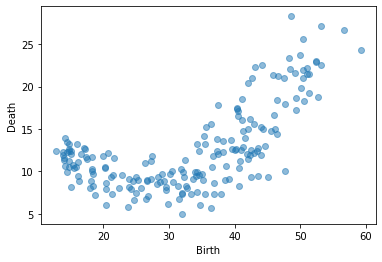

In [8]:
df = pd.read_csv("Crude-BirthDeath-Rate.csv")
plt.scatter(df["Birth"],df["Death"],alpha=0.5)
plt.xlabel("Birth")
plt.ylabel("Death")
plt.show()

It seems like the data can be modelled by a mixture of two gaussians, one in the bottom left corner with a medium spread (at an angle of -20°), another a bit at the right of center with a greater spread (at an angle of 60°). A more general argument could be that this model "biological" data, which in a population almost always follow a gaussian distribution, so here it could be the sum of different groups each following their own gaussian distribution, the latent variables z_i being the population each sample belongs to, the alpha_j then being the percentage this particular group makes in the total population.

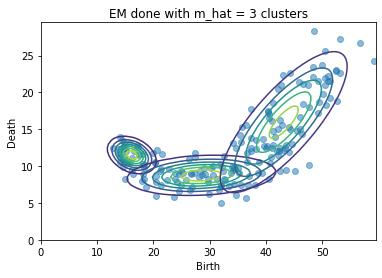

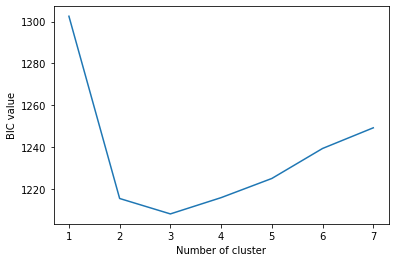

In [9]:
#6)
samples = [(x,y) for x,y in zip(df["Birth"].to_numpy(),df["Death"].to_numpy())]

#Computing the BIC
kmax = 7 #Max number of clusters to test
num_iterations = 150 #Number of iterations in the EM algorithm

m = []
loglike = []

for num_clusters in range(1,kmax+1):
    pi, sigma, mu, loglikelihood = EM(samples,num_clusters,num_iterations)
    m.append(-loglikelihood[-1] + (6*num_clusters-1)*np.log(len(samples))/2)
    loglike.append(loglikelihood[-1])

m_hat = np.argmin(m)+1 #Because index 0 is for k=1

pi, sigma, mu, loglikelihood = EM(samples,m_hat,150) #We recompute the clustering with m_hat clusters

#Plotting
x, y = np.mgrid[0:60:.5, 0:30:.5]
data = np.dstack((x, y))

for i in range(m_hat):
    rv = sp.multivariate_normal(mu[i], sigma[i])
    z = rv.pdf(data)
    plt.contour(x, y, z)
plt.scatter([s[0] for s in samples],[s[1] for s in samples],alpha=0.5)
plt.title("EM done with m_hat = %i clusters"%m_hat)
plt.xlabel("Birth")
plt.ylabel("Death")
plt.show()

plt.plot(np.arange(1,kmax+1),m)
plt.xlabel("Number of cluster")
plt.ylabel("BIC value")
plt.show()

In [3]:
#Exercice 3
#1)
#N is the number of samples
def importanceSampling(N,f,p,q,sampling_function):
    i=0
    
    weights=[]
    f_eval=[]
    
    while i<N:
        x = sampling_function()
        
        if p(x) != 0:
            weights.append(p(x)/q(x))
            f_eval.append(f(x))
            i+=1
        
    weights /= 1/N*np.sum(weights)
    
    value = 1/N*np.sum(weights@f_eval)
    
    return (value,weights)

In [4]:
#2)
def f(x):
    if (x>0):
        return 2*np.sin(np.pi/1.5*x)
    else:
        return 0
def p(x):
    if (x>0):
        return pow(x,1.65-1)*np.exp(-x**2/2)
    else:
        return 0

def q(x):
    return 2/np.sqrt(2*np.pi*1.5)*np.exp(-(0.8-x)**2/2*1.5)

sampling_f = (lambda : np.random.normal(0.8,1.5))


array_N = [10,100,1000,10000]

for N in array_N:
    value_array = []
    
    for i in range(100):
        (value,_) = importanceSampling(N,f,p,q,sampling_f)
        value_array.append(value)
        
    print("For N = %i"%N)
    print("The mean is %f"%np.mean(value_array))
    print("The variance is %f\n"%np.var(value_array))

For N = 10
The mean is 0.318602
The variance is 0.315839

For N = 100
The mean is 0.324735
The variance is 0.050387

For N = 1000
The mean is 0.308117
The variance is 0.010179

For N = 10000
The mean is 0.294957
The variance is 0.012579



In [5]:
#3)
def qshift(x):
    return 2/np.sqrt(2*np.pi*1.5)*np.exp(-(6-x)**2/2*1.5)

N = 10000

value_array = []
valueshift_array = []

weights_array = []
weightsshift_array = []

for i in range(100):
    (value,weights) = importanceSampling(N,f,p,q,sampling_f)
    value_array.append(value)
    weights_array.append(weights)
    
    (valueshift,weightsshift) = importanceSampling(N,f,p,qshift,sampling_f)
    valueshift_array.append(valueshift)
    weightsshift_array.append(weightsshift)

For the original sampling :
The mean is 0.310608
The variance is 0.001724

For the shifted sampling :
The mean is 0.731152
The variance is 0.000095



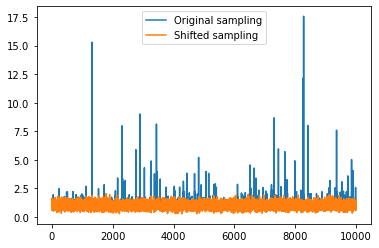

In [6]:
print("For the original sampling :")
print("The mean is %f"%np.mean(value_array))
print("The variance is %f\n"%np.var(value_array))
    
print("For the shifted sampling :")
print("The mean is %f"%np.mean(valueshift_array))
print("The variance is %f\n"%np.var(valueshift_array))

plt.plot(np.mean(weights_array,axis=0), label="Original sampling")
plt.plot(np.mean(weightsshift_array,axis=0), label="Shifted sampling")
plt.legend()
plt.show()

For µ=6, the weigts are much more flat compared to the original sampling which has strong peaks. This was expected when looking at the two graphs with µ=0.8 and µ=6 in the homework subject.

In [93]:
#5)
def EM_importance_sampling(X,k,num_iterations,w_tilde):
    n = len(X)
    d = len(X[0])
    
    xmean = np.mean(X)
    sigma2 = np.sum([np.linalg.norm(x - xmean)**2 for x in X])/n

    #We draw samples at random as initial means for the clusters
    Xtemp = copy.deepcopy(X)
    
    mu = np.zeros((k,d))
    for i in range(k):
        r = np.random.randint(len(Xtemp))
        mu[i] = Xtemp[r]
        Xtemp.pop(r)
    
    sigma = np.array([sigma2/k*np.eye(d) for _ in range(k)])
    alpha = np.ones(k)/k
    
    p = np.full((n,k),1/k)
    X = np.array(X) #Sometimes the np float64 mess things up
    
    for _ in range(num_iterations):
        for i in range(n):
            for j in range(k): 
                p[i,j] = alpha[j]*sp.multivariate_normal.pdf(x=X[i],mean=mu[j],cov=sigma[j])
            
            if (np.sum(p[i]) != 0):
                p[i] /= np.sum(p[i])
            
            p[i] *= w_tilde[i]
        
        for j in range(k):
            alpha[j] = 0
            mu[j] = np.zeros(d)
            
            for i in range(n):
                alpha[j] += p[i,j]
                mu[j] += p[i,j]*X[i]
            
            if alpha[j] != 0:
                mu[j] /= alpha[j]
            
            sigma[j] = np.zeros((d,d))
            for i in range(n):
                v = np.array(X[i] - mu[j]).reshape(-1,1)
                sigma[j] += p[i,j]*v@v.T
            
            if alpha[j] != 0:
                sigma[j] /= alpha[j]
            
            alpha[j] /= n
          
    return alpha, sigma, mu

In [118]:
n_iter_EM = 20
n_iter_population = 8
M = 4
d = 5
n = 1000 #Importance sampling parameter
b = 0.4

In [119]:
alpha = np.full(M,1/M)
mu = sp.multivariate_normal.rvs(mean=[0]*d,cov=np.eye(d),size=M)
sigma = np.full((M,d,d),np.eye(d))

for k in range(n_iter_population):
    #Importance sampling estimate
    samples = np.zeros((n,d))
    weights = np.zeros(n)
    
    for i in range(n):
        while weights[i] == 0.:
            cl = discreteRV(alpha,range(M))
            samples[i] = sp.multivariate_normal.rvs(mean=mu[cl], cov=sigma[cl],size=1)

            sample_nu = np.copy(samples[i])
            sample_nu[1] -= b*(sample_nu[0]**2 - 1)
            weights[i] = sp.multivariate_normal.pdf(x=sample_nu,mean=np.zeros(d),cov=np.eye(d))/np.sum([alpha[j]*sp.multivariate_normal.pdf(x=samples[i],mean=mu[j],cov=sigma[j]) for j in range(M)])
        
    weights *= n/np.sum(weights)
    alpha, sigma, mu = EM_importance_sampling(samples.tolist(),M,n_iter_EM,weights)

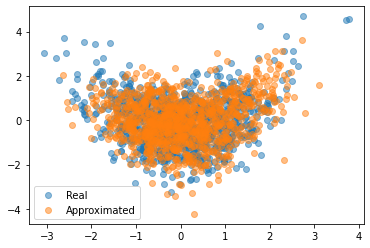

In [126]:
N = 1000

M = len(mu)
samples = np.zeros((N,d))
samples_real = np.zeros((N,d))

for i in range(N):
    cl = discreteRV(alpha,range(M))
    samples[i] = sp.multivariate_normal.rvs(mean=mu[cl], cov=sigma[cl],size=1)
    
    samples_real[i] = sp.multivariate_normal.rvs(mean=np.zeros(d), cov=np.eye(d),size=1)
    samples_real[i][1] += b*(samples_real[i][0]**2 - 1)


plt.scatter(samples_real[:,0],samples_real[:,1], alpha=0.5, label="Real")
plt.scatter(samples[:,0],samples[:,1], alpha=0.5, label="Approximated")
plt.legend()
plt.show()